In [1]:
import numpy as np
from scipy.stats import poisson
from scipy.special import digamma, gammaln
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility

In [2]:
lambdas = np.array([2.0, 10.0, 50.0])  # Poisson parameters
n_samples = 1000  # Number of samples to generate
assignments = np.random.choice(np.arange(len(lambdas)), size=n_samples, p=[0.3, 0.5, 0.2])
# Generate samples from the Poisson distribution
poisson_samples = [poisson.rvs(lambdas[assignment]) for assignment in assignments]
poisson_samples = np.array(poisson_samples)

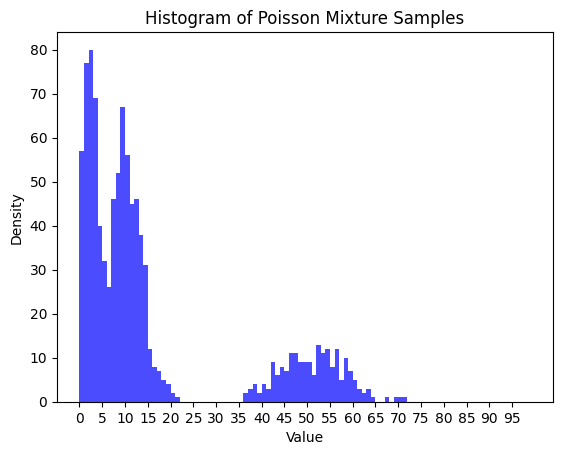

In [3]:
counts, bins = np.histogram(poisson_samples, bins=np.arange(0, 100, 1))
plt.stairs(counts, bins, fill=True, color='blue', alpha=0.7)
plt.xticks(np.arange(0, 100, 5))
plt.title('Histogram of Poisson Mixture Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [4]:
n_clusters = len(lambdas)
alpha = np.ones(n_clusters) * 0.1 # Dirichlet prior for cluster weights
prior_shape = np.ones(n_clusters) * 0.1  # Prior for Poisson parameters
prior_rate = np.ones(n_clusters) * 0.1  # Prior for Poisson parameters
assignment_proba = np.random.random((n_samples, n_clusters))

In [5]:
def update_zeta(proba, alpha):
    return proba.sum(0) + alpha

In [6]:
def update_shape(proba, prior_shape):
    return (proba * poisson_samples.reshape(-1, 1)).sum(0) + prior_shape
def update_rate(proba, prior_rate):
    return proba.sum(0) + prior_rate

In [7]:
def update_assignment_proba(proba, zeta, shape, rate):
    proba = digamma(zeta) - shape / rate
    proba = (
        poisson_samples.reshape(-1, 1)
        * (digamma(shape) - np.log(rate)).reshape(1, -1)
        ) + proba.reshape(1, -1)
    proba = np.exp(proba - np.max(proba, axis=1, keepdims=True))
    proba /= proba.sum(axis=1, keepdims=True)
    return proba

In [8]:
def update_params(assignment_proba, alpha, prior_shape, prior_rate):
    zeta = update_zeta(assignment_proba, alpha)
    shape = update_shape(assignment_proba, prior_shape)
    rate = update_rate(assignment_proba, prior_rate)
    return zeta, shape, rate

In [9]:
def dirichlet_expectation_log(alpha):
    return digamma(alpha) - digamma(alpha.sum(-1, keepdims=True))
def gamma_expectation(shape, rate):
    return shape / rate
def gamma_expectation_log(shape, rate):
    return digamma(shape) - np.log(rate)
def log_factorial(x):
    return gammaln(x + 1)

In [10]:
def elbo(samples, proba, alpha, prior_shape, prior_rate):
    zeta, shape, rate = update_params(proba, alpha, prior_shape, prior_rate)
    return (
        (proba * dirichlet_expectation_log(zeta)).sum()
        + (proba * (samples.reshape(-1, 1) * gamma_expectation_log(shape, rate)
                   - gamma_expectation(shape, rate)
                   - log_factorial(samples).reshape(-1, 1))).sum()
        + gammaln(alpha.sum()) - gammaln(alpha).sum()
        - gammaln(zeta.sum()) + gammaln(zeta).sum()
        + ((alpha - zeta) * dirichlet_expectation_log(zeta)).sum()
        + (prior_shape * np.log(prior_rate) - gammaln(prior_shape)).sum()
        - (shape * np.log(rate) - gammaln(shape)).sum()
        + ((prior_shape - shape) * gamma_expectation_log(shape, rate)).sum()
        - ((prior_rate - rate) * gamma_expectation(shape, rate)).sum()
        - (assignment_proba * np.log(assignment_proba + 1e-10)).sum()
    )

In [11]:
previous_elbo = -np.inf
for _ in range(100):  # Run for a number of iterations
    zeta, shape, rate = update_params(assignment_proba, alpha, prior_shape, prior_rate)
    assignment_proba = update_assignment_proba(poisson_samples, zeta, shape, rate)
    current_elbo = elbo(poisson_samples, assignment_proba, alpha, prior_shape, prior_rate)
    print(f"ELBO: {current_elbo:.4f}")
    if current_elbo - previous_elbo < 1e-6:
        break
    previous_elbo = current_elbo

ELBO: -10023.3094
ELBO: -4128.1935
ELBO: -3736.2555
ELBO: -3637.6193
ELBO: -3552.5339
ELBO: -3496.0917
ELBO: -3470.2533
ELBO: -3461.5655
ELBO: -3459.0491
ELBO: -3458.3540
ELBO: -3458.1646
ELBO: -3458.1132
ELBO: -3458.0992
ELBO: -3458.0955
ELBO: -3458.0944
ELBO: -3458.0942
ELBO: -3458.0941
ELBO: -3458.0941
ELBO: -3458.0940
ELBO: -3458.0940
ELBO: -3458.0940


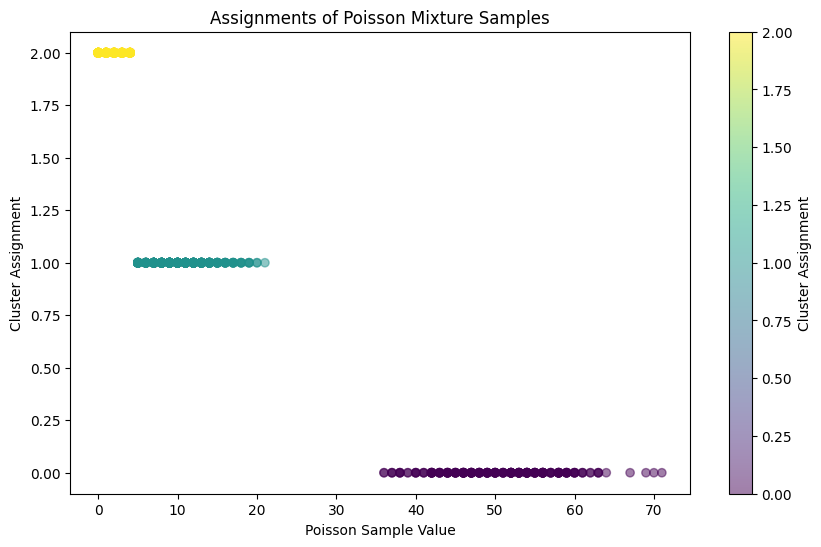

In [12]:
assignments = np.argmax(assignment_proba, axis=1)
plt.figure(figsize=(10, 6))
plt.scatter(poisson_samples, assignments, c=assignments, cmap='viridis', alpha=0.5)
plt.title('Assignments of Poisson Mixture Samples')
plt.xlabel('Poisson Sample Value')
plt.ylabel('Cluster Assignment')
plt.colorbar(label='Cluster Assignment')
plt.show()